In [1]:
import os
from math import pi
import numpy as np
import random
import itertools
import scipy.optimize as opt
import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# from qiskit_aer.noise import NoiseModel
# from qiskit_ibm_provider import IBMProvider
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms import utils
from qiskit.visualization import plot_state_city


from ground_state import get_ground_state, measure_gs_basis_list

In [2]:
shots = 100
epsilon_loss = 1e-3 # loss added if test_counts entry is not found
epsilon_parameters=0.1 # scaling factor for initial random parameters (chosen between 0 to 2pi otherwise)

n_qubits = 3
n_bases = 27
depth = 10

delta = 1.0
h = 1.0
J = 1.0

max_iter = 300

param_name = "theta"

# save checkpoints in case the connection to qpu breaks
# useful for running on real qpu, but not necessary for local simulation
have_checkpoints = False
checkpoint_path = None

trial = '_plot'

In [3]:
rng = np.random.default_rng()

In [4]:
# backend = AerSimulator()
# sampler = Sampler.from_backend(backend)
# pm = generate_preset_pass_manager(backend=backend)

simulator_ideal = AerSimulator()
# sampler_ideal = Sampler.from_backend(simulator_ideal)
pm_ideal = generate_preset_pass_manager(backend=simulator_ideal, optimization_level=1)

# sampler = sampler_ideal
pm = pm_ideal

In [5]:
def create_ghz_state(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n - 1):
        qc.cx(i, i + 1)
    return qc

def get_circ_for_basis(qc: QuantumCircuit, basis: str):
    circ = qc.copy()
    for i, s in enumerate(basis[::-1]): # here, I am using the same endian convention as qiskit, where the last bit represent the first qubit
        if s == 'Z':
            pass
        elif s == 'X':
            circ.ry(-pi/2, i)
        elif s == 'Y':
            circ.rx(pi/2, i)
        else:
            raise ValueError(f"{s} is invalid basis")

    circ.measure_all()

    return circ

def get_isa_circ_list_for_bases(qc: QuantumCircuit, basis_list, pass_manager):
    circ_list = [get_circ_for_basis(qc, basis) for basis in basis_list]
    isa_circ_list = pass_manager.run(circ_list)
    return isa_circ_list


def measure_isa_circ_list_fs(isa_circ_list, basis_list, shots=shots):
    sampler = Sampler()
    result_list = sampler.run(isa_circ_list, shots=shots).result()
    counts_list = [result.data.meas.get_counts() for result in result_list]
    results_dic = {basis:counts for (basis, counts) in zip(basis_list, counts_list)}
    return results_dic


def get_basis_list(n_bases,n_qubits):
    bases = ["X", "Y", "Z"]
    basis_list = ["".join(p) for p in itertools.product(bases, repeat=n_qubits)]
    culled_basis_list = random.sample(basis_list, n_bases)
    return culled_basis_list




# def measure_circ_for_all_basis(qc, basis_list, shots=total_shots, sampler=None):
#     results_dic = {}
#     qc_list = [get_circ_for_basis(qc, basis, simulator) for basis in basis_list]
#     job = simulator.run(qc_list, shots=shots)
#     result = job.result()
#     counts_list = result.get_counts()
#     results_dic = {basis:counts for (basis, counts) in zip(basis_list, counts_list)}
    
#     return results_dic

In [6]:
basis_list = get_basis_list(n_bases, n_qubits)

In [7]:
gs_state = get_ground_state(n_qubits, delta=delta, h=h, J=J)
gs_measurements = measure_gs_basis_list(n_qubits, basis_list, shots, delta=delta, h=h, J=J)

In [8]:
print(basis_list)

['XXX', 'YXY', 'XXY', 'YXZ', 'ZZY', 'ZYX', 'XZY', 'ZXZ', 'XYX', 'YZZ', 'YZY', 'XYY', 'YYZ', 'XZZ', 'YZX', 'ZYY', 'ZYZ', 'ZZX', 'ZXY', 'YXX', 'ZXX', 'XXZ', 'XYZ', 'YYX', 'YYY', 'XZX', 'ZZZ']


In [9]:
print(gs_measurements)

{'XXX': {'001': 9, '010': 31, '011': 10, '100': 11, '101': 31, '110': 8}, 'YXY': {'000': 13, '001': 10, '010': 15, '011': 10, '100': 8, '101': 15, '110': 11, '111': 18}, 'XXY': {'000': 1, '001': 6, '010': 23, '011': 20, '100': 17, '101': 24, '110': 5, '111': 4}, 'YXZ': {'000': 4, '001': 22, '010': 5, '011': 28, '100': 2, '101': 20, '110': 1, '111': 18}, 'ZZY': {'010': 15, '011': 8, '100': 22, '101': 38, '110': 8, '111': 9}, 'ZYX': {'000': 8, '001': 2, '010': 8, '011': 3, '100': 16, '101': 27, '110': 15, '111': 21}, 'XZY': {'000': 14, '001': 23, '010': 9, '011': 9, '100': 12, '101': 17, '110': 6, '111': 10}, 'ZXZ': {'001': 5, '011': 7, '100': 6, '101': 38, '110': 5, '111': 39}, 'XYX': {'000': 15, '001': 5, '010': 15, '011': 12, '100': 7, '101': 23, '110': 2, '111': 21}, 'YZZ': {'001': 38, '010': 7, '011': 12, '101': 29, '110': 10, '111': 4}, 'YZY': {'000': 12, '001': 17, '010': 22, '100': 14, '101': 16, '111': 19}, 'XYY': {'000': 4, '001': 21, '010': 23, '011': 7, '100': 7, '101': 22, '

In [10]:
def initialize_theta_random(circ_depth=10, num_qbits=3):
    """
    Initialize the theta parameter vector
    :param circ_depth: int, number of parameterized layers in circuit
    :param num_qbits: int, number of qbits
    :return: np.array, values of theta
    """

    theta = rng.random(size=(circ_depth, num_qbits))
    theta = 2*pi*epsilon_parameters*theta
    return theta

In [11]:
def construct_variational_circ_ansatz(num_qbits, circ_depth, param_name = param_name):
    """
    Generate a parameterized variational quantum circuit
    
    """

    num_parameters = num_qbits * circ_depth
    theta_vec = ParameterVector(param_name, length=num_parameters)
    var_circ = QuantumCircuit(num_qbits)


    for layer in range(circ_depth - 1):
        # Compute if layer is odd or even to apply rx or ry gate to circuit
        is_odd_step = (layer + 1) % 2

        for qbit in range(num_qbits):
            if is_odd_step:
                var_circ.rx(theta_vec[layer * num_qbits + qbit], qbit)
            else:
                var_circ.ry(theta_vec[layer * num_qbits + qbit], qbit)

        # Apply CX gates
        for qbit in range((1-is_odd_step), num_qbits-1, 2):
            # isOddStep may subtract 1 if True, to correctly apply cx gate location
            var_circ.cx(qbit , qbit + 1)
            var_circ.barrier() # for visualization only

    for qbit in range(num_qbits):  # bonus layer at the end only has rx gates and no cx
        var_circ.rx(theta_vec[(circ_depth - 1) * num_qbits + qbit], qbit)

    return var_circ, theta_vec


In [12]:
ansatz, param_vec = construct_variational_circ_ansatz(n_qubits, depth, param_name=param_name)

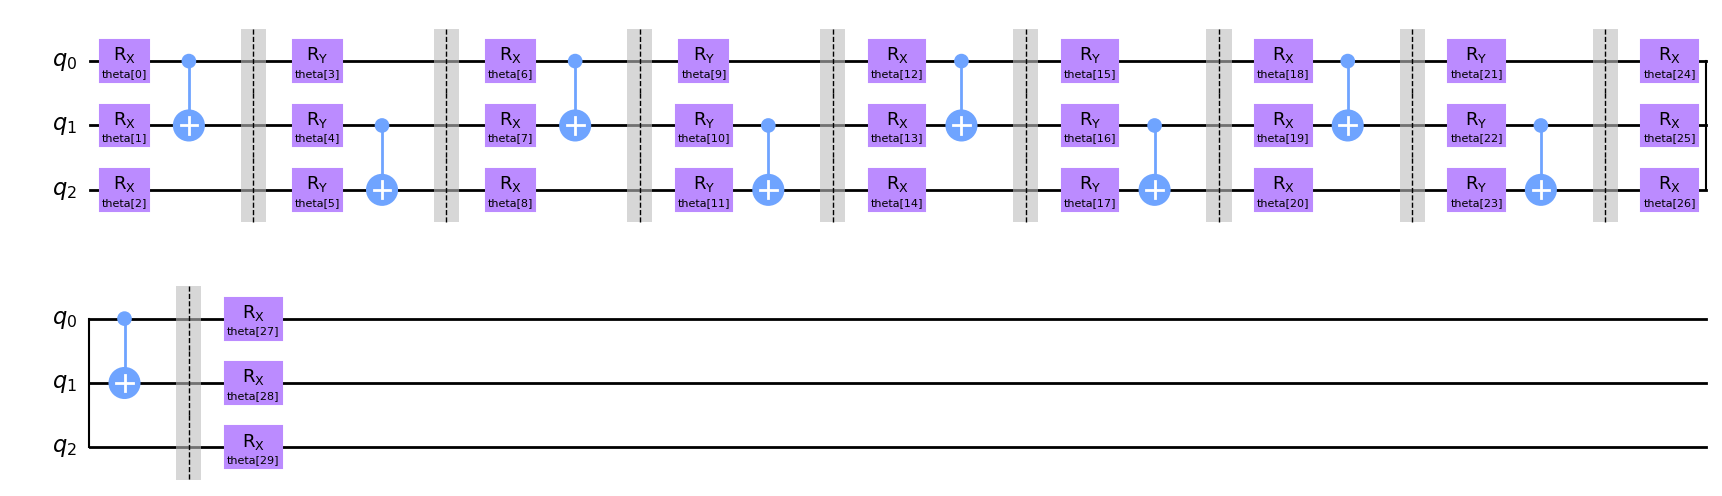

In [13]:
ansatz.draw(output="mpl", style="clifford")

In [14]:
ansatz_isa_list = get_isa_circ_list_for_bases(ansatz, basis_list, pm)

In [15]:
def get_ansatz_output(ansatz_isa_list, parameters, basis_list, shots, param_placeholder=param_vec):
    circ_run_list = [circ.assign_parameters({param_placeholder:parameters}) for circ in ansatz_isa_list]
    return measure_isa_circ_list_fs(isa_circ_list=circ_run_list, basis_list=basis_list, shots=shots)

In [16]:
def KL_divergence(true_data, test_data, epsilon_loss = epsilon_loss):
    loss = 0

    # here, let me assume true data and test data can have different number of shots
    # but the shot in each basis should be the same
    true_data_total_shots = sum(list(true_data.values())[0].values())
    test_data_total_shots = sum(list(test_data.values())[0].values())

    for basis in true_data: # just a note that if there are hallucinated measurements in 
        # bases/states not included in the true data then the kl divergence will not account for these (at least as presented in the paper)
        for state in true_data[basis]:
            true_counts = true_data[basis][state]
            test_counts = test_data[basis].get(state, 0)
            true_prob   = true_counts / true_data_total_shots
            test_prob   = test_counts / test_data_total_shots
            loss += true_prob *(np.log((true_prob)/(test_prob +epsilon_loss)))

    return loss / len(true_data)

In [17]:
global loss_values
global thetas

loss_values = []
thetas = []

In [18]:
def compute_kl_loss(theta_vector, ansatz_isa_list,  basis_list, true_data, shots, param_placeholder=param_vec, \
        print_message=True, have_checkpoints=have_checkpoints, checkpoint_path=checkpoint_path):
    # theta = np.reshape(theta_vector, (circ_depth, num_qbits))
    # tempcirc = construct_variational_circ(theta=theta)
    test_data = get_ansatz_output(ansatz_isa_list=ansatz_isa_list, parameters=theta_vector, basis_list=basis_list, \
        shots=shots, param_placeholder=param_placeholder)
    # test_data = measure_circ_for_all_basis(qc = tempcirc, basis_list=basis_list, simulator=simulator)
    loss = KL_divergence(true_data, test_data) + \
        KL_divergence(test_data, true_data) # symmetrizing the loss

    global loss_values
    global thetas 
    loss_values.append(loss)
    thetas.append(theta_vector)

    num_iter = len(loss_values)

    if print_message:
        print(f"Iteration {num_iter:5}; current loss is {loss}")

    if have_checkpoints:
        # save checkpoints in case the connection to qpu breaks
        # useful for running on real qpu, but not necessary for local simulation
        np.save(os.path.join(checkpoint_path, f"theta_iter{num_iter}.npy"), thetas)
    
    return loss


In [19]:
# wraps the function with the all arguments but theta vector already filled

def compute_kl_loss_filled(theta_vector):
    return compute_kl_loss(theta_vector, ansatz_isa_list, basis_list, gs_measurements, shots, param_vec, print_message=True)

def compute_kl_loss_filled_quiet(theta_vector):
    return compute_kl_loss(theta_vector, ansatz_isa_list, basis_list, gs_measurements, shots, param_vec, print_message=False)


In [20]:
loss_proper_values = [] # the loss function L(theta)
# by contrast, if we do not use the callback, we get L(theta+-deltaTheta) instead in SPSA algorithm


def callback(nev, x, fx, a, flag):
    print(f"Number of call {nev:5}; current loss is {fx}")
    loss_proper_values.append(fx)

In [21]:
%%time

theta = initialize_theta_random(circ_depth=depth, num_qbits = n_qubits)
theta_vector = np.reshape(theta, theta.size)
circ_depth, num_qbits = theta.shape

spsa = SPSA(maxiter=max_iter, callback=callback)
c=0.1258
A=0.3186
a1=0.4739
alpha=0.6374
gamma=0.06059
(lr, p) = spsa.calibrate(compute_kl_loss_filled, theta_vector, c=c, stability_constant = A, target_magnitude=a1, alpha=alpha, gamma=gamma)
spsa.learning_rate = lr
spsa.perturbation = p

# args = (ansatz_isa_list, basis_list, GHZ_measurement, shots, param_vec)

# results = opt.minimize(compute_kl_loss, theta_vector, args = args, method = "Powell", options={"maxiter":max_iter})

results = spsa.minimize(compute_kl_loss_filled, theta_vector)

Iteration     1; current loss is 2.5203298583275813
Iteration     2; current loss is 2.665125946590339
Iteration     3; current loss is 2.4813544303423605
Iteration     4; current loss is 2.908026451950014
Iteration     5; current loss is 2.3987908526272
Iteration     6; current loss is 2.7695117114581738
Iteration     7; current loss is 2.5870193107101778
Iteration     8; current loss is 2.3346145034251506
Iteration     9; current loss is 2.473417233461814
Iteration    10; current loss is 2.397396105486526
Iteration    11; current loss is 2.6517007795689804
Iteration    12; current loss is 2.333225046398168
Iteration    13; current loss is 2.3540175916472594
Iteration    14; current loss is 2.8238901148661917
Iteration    15; current loss is 2.5231535574761965
Iteration    16; current loss is 2.6597054225229497
Iteration    17; current loss is 2.491444366441581
Iteration    18; current loss is 2.603395238945538
Iteration    19; current loss is 2.9529857091513514
Iteration    20; curre

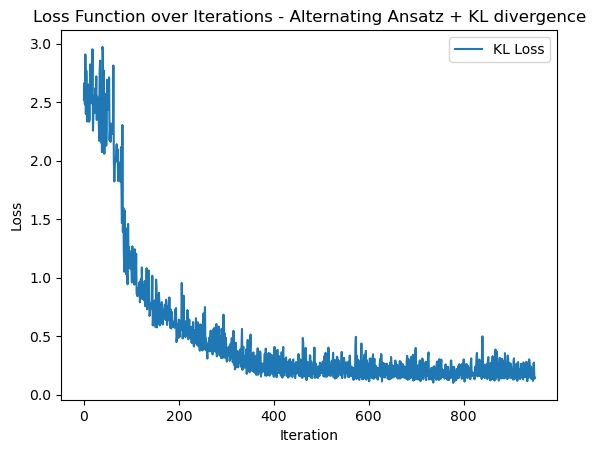

In [22]:
fig, ax = plt.subplots()
ax.plot(loss_values, label=f"KL Loss")
# plt.ylim(0, 30)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title(f"Loss Function over Iterations - Alternating Ansatz + KL divergence")
ax.legend()

# fig.savefig("loss_curve.png")

In [23]:
def compute_fidelity(psi, phi):
    """
    Compute the fidelity (a measure of similarity) between the two states
    :param psi: qiskit.Statevector, our target state |psi>
    :param phi: qiskit.Statevector, our estimated state |phi>
    :return: float, fidelity
    """

    fidelity = qiskit.quantum_info.state_fidelity(psi, phi)
    print(f"psi: {psi}, phi: {phi}")
    # fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # plot_bloch_multivector(psi)
    # axes[0].set_title("psi")
    # plot_bloch_multivector(phi)
    # axes[1].set_title("phi")
    return fidelity



ansatz_state = Statevector.from_instruction(ansatz.assign_parameters({param_vec : results.x}))

final_fidelity = qiskit.quantum_info.state_fidelity(gs_state, ansatz_state)

In [24]:
print(f"target state: {gs_state}\nansatz: {ansatz_state}")

target state: Statevector([ 0.        +0.j,  0.        +0.j,  0.        +0.j,
             -0.40824829+0.j,  0.        +0.j,  0.81649658+0.j,
             -0.40824829+0.j,  0.        +0.j],
            dims=(2, 2, 2))
ansatz: Statevector([-0.01780352-1.93051100e-02j,  0.00725028-3.19844603e-02j,
             -0.02264202+2.80261062e-02j, -0.13152576+3.97367464e-01j,
              0.03548833-1.99014549e-04j,  0.21420418-7.85897418e-01j,
             -0.08575131+3.85906784e-01j, -0.00974437-2.42239124e-02j],
            dims=(2, 2, 2))


In [25]:
print(final_fidelity)

0.9938766747734351


In [26]:
print(results.x)

[-0.37680729  0.11912701 -0.32488133  0.20425913  1.50590265  0.15021506
  0.77561354 -0.68470002  0.01439496  0.67495567  1.43837649  0.22233819
 -0.14761736  0.19318343 -0.13467638  2.03250098  1.36813482 -0.32215444
 -0.02806122  0.16517511 -0.08218394 -0.24747449 -0.55387972  0.11572638
  0.42451731  1.57742504 -0.29037193 -0.15757136  0.10509166  0.22053296]


In [27]:
np.save(f"saved/params_training_s{trial}.npy", thetas)
np.save(f"saved/loss_training_s{trial}.npy", loss_values)
np.save(f"saved/loss_training_proper_s{trial}.npy", loss_proper_values)
np.save(f"saved/final_theta_s{trial}.npy", results.x)
np.save(f"saved/fidelity_s{trial}.npy", final_fidelity)

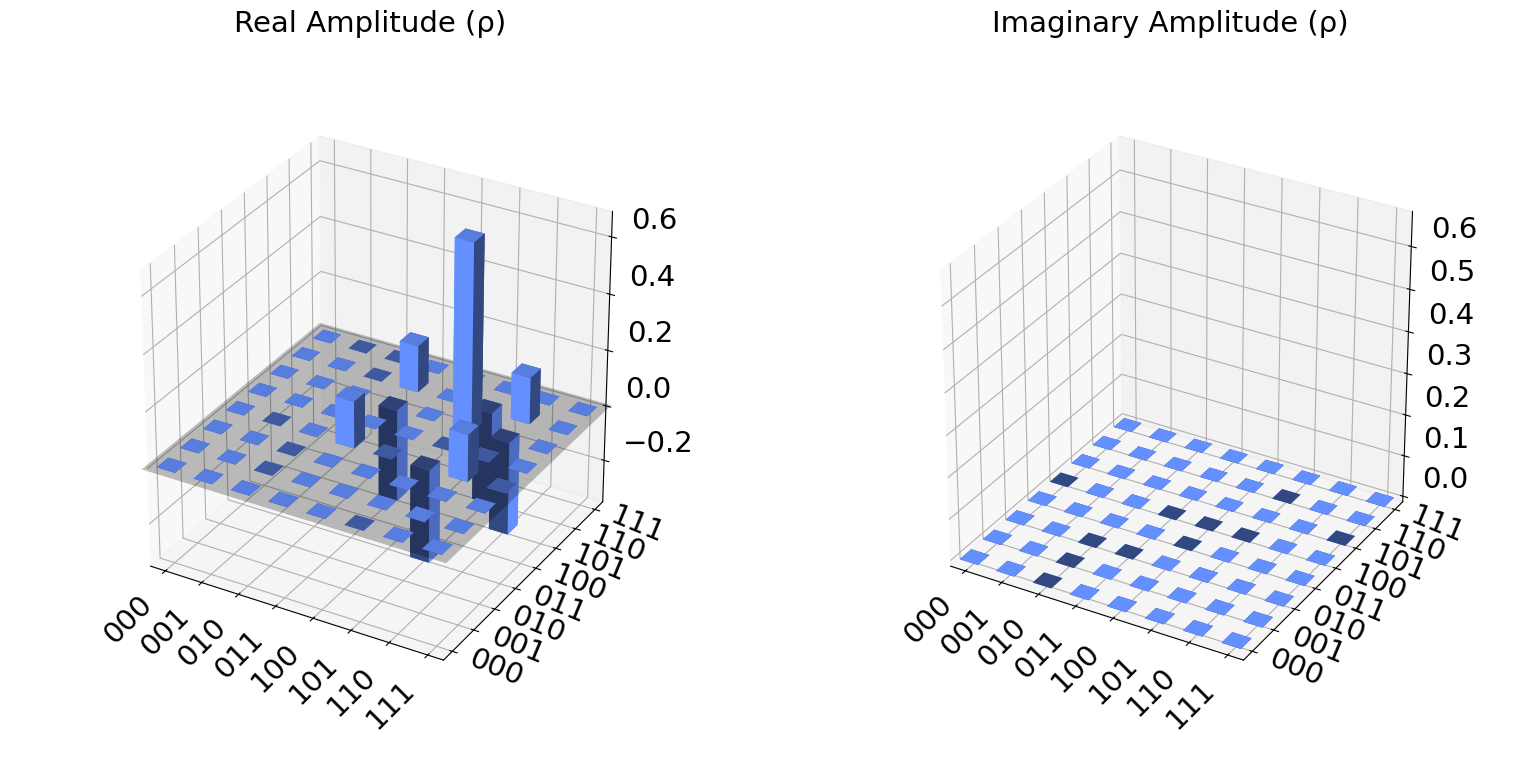

In [28]:
plot_state_city(gs_state, title=None)

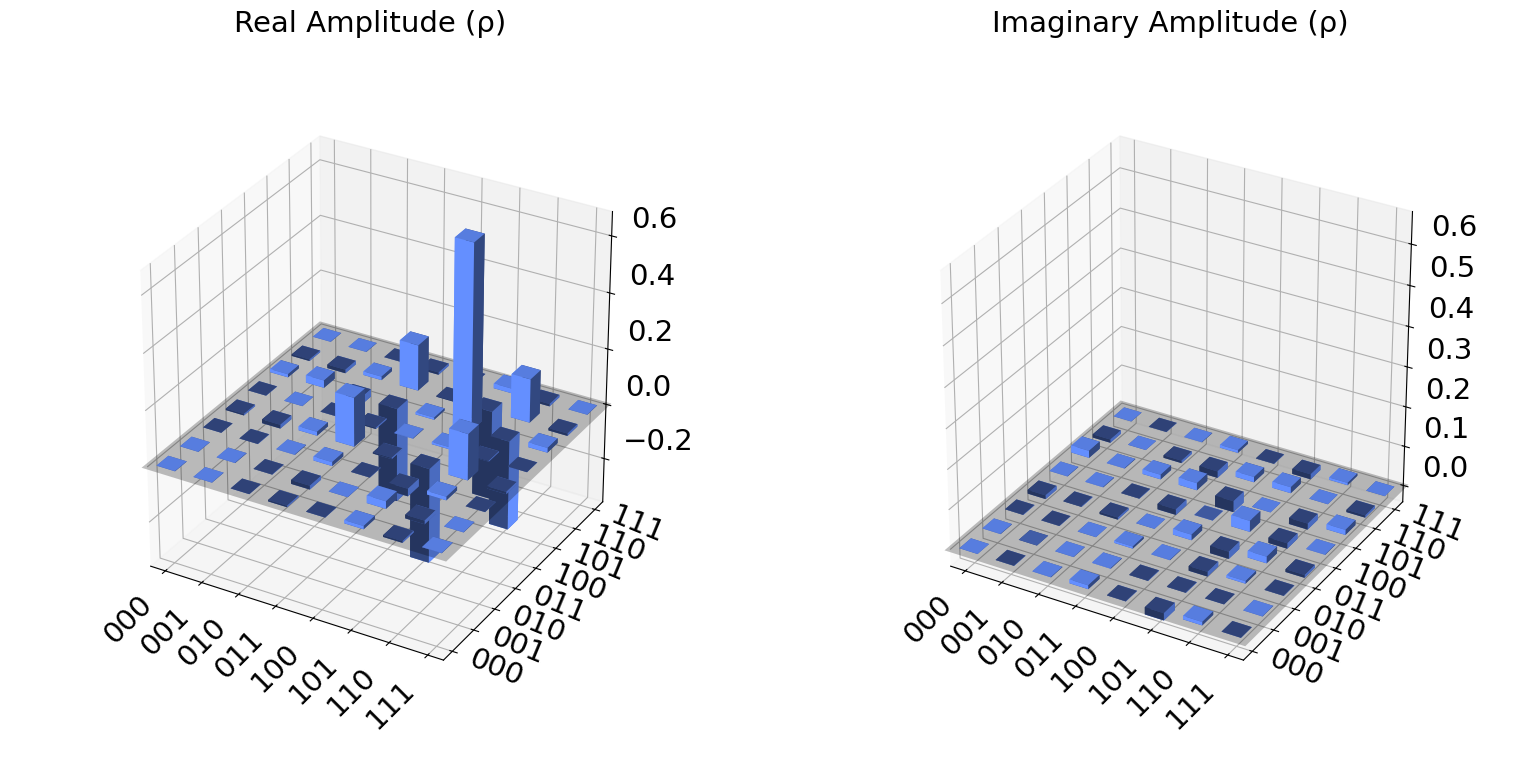

In [29]:
plot_state_city(ansatz_state, title=None)